In [1]:
import nibabel                      as nib
import nibabel.freesurfer.mghformat as mgh
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from scipy import ndimage

def read_mgz_file(filepath):
    """Read and load volume"""
    # Read file
    scan = mgh.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def convertersize(volume):
    """convertersize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 128
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 270, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_mgz_file(path)
    #  convertersize
    volume = convertersize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

Dimension of the CT scan is: (128, 128, 128)


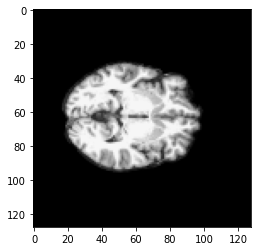

In [18]:
scan = process_scan('Scans_CN/OAS30001_MR_d0129.mgz')uykkuy
image = scan
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[64, :, :]), cmap="gray")

## Reading data

In [5]:
# Folder "Scans_CN" consist of subjects who remained cognitively converters for the whole study.
CN_scan_paths = [
    os.path.join(os.getcwd(), "Scans_CN", x)
    for x in os.listdir("Scans_CN")
]
# Folder "Scans_Converters" consist of subjects who converted from CN to MCI > 0.
converters_scan_paths = [
    os.path.join(os.getcwd(), "Scans_Converters", x)
    for x in os.listdir("Scans_Converters")
]

print("MRI scans for patients remaining CN: " + str(len(CN_scan_paths)))
print("MRI scans for patients converting to AD: " + str(len(converters_scan_paths)))

MRI scans for patients remaining CN: 319
MRI scans for patients converting to AD: 126


In [6]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
CN_scans = np.array([process_scan(path) for path in CN_scan_paths])
converters_scans = np.array([process_scan(path) for path in converters_scan_paths])

# For the converters assign 1, for the CN subjects assign 0.
CN_labels = np.array([0 for _ in range(len(CN_scans))])
converters_labels = np.array([1 for _ in range(len(converters_scans))])

In [7]:
# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((CN_scans[:223], converters_scans[:88]), axis=0)
y_train = np.concatenate((CN_labels[:223], converters_labels[:88]), axis=0)
x_val = np.concatenate((CN_scans[223:], converters_scans[88:]), axis=0)
y_val = np.concatenate((CN_labels[223:], converters_labels[88:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0]))

Number of samples in train and validation are 311 and 134.


In [8]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

In [11]:
def get_model(width=128, height=128, depth=128):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=5, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=5, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=5, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=5, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=128)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 128, 1) 0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 124, 124, 124, 64) 8064      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 62, 62, 62, 64)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 62, 62, 62, 64)    256       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 58, 58, 58, 64)    512064    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 29, 29, 29, 64)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 29, 29, 29, 64)    256   

In [12]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
156/156 - 78s - loss: 0.6515 - acc: 0.6238 - val_loss: 0.9784 - val_acc: 0.2836
Epoch 2/100
156/156 - 67s - loss: 0.6345 - acc: 0.7042 - val_loss: 0.6516 - val_acc: 0.7164
Epoch 3/100
156/156 - 68s - loss: 0.6031 - acc: 0.7363 - val_loss: 0.9785 - val_acc: 0.7164
Epoch 4/100
156/156 - 67s - loss: 0.5939 - acc: 0.7106 - val_loss: 1.9766 - val_acc: 0.7164
Epoch 5/100
156/156 - 67s - loss: 0.5972 - acc: 0.7331 - val_loss: 74.0126 - val_acc: 0.7164
Epoch 6/100
156/156 - 68s - loss: 0.5620 - acc: 0.7042 - val_loss: 14.1910 - val_acc: 0.7164
Epoch 7/100
156/156 - 67s - loss: 0.5718 - acc: 0.7395 - val_loss: 53.3757 - val_acc: 0.7164
Epoch 8/100
156/156 - 68s - loss: 0.5715 - acc: 0.7170 - val_loss: 2.9070 - val_acc: 0.7164
Epoch 9/100
156/156 - 68s - loss: 0.5839 - acc: 0.7138 - val_loss: 2.0723 - val_acc: 0.7164
Epoch 10/100
156/156 - 68s - loss: 0.5656 - acc: 0.7267 - val_loss: 160.4640 - val_acc: 0.7164
Epoch 11/100
156/156 - 68s - loss: 0.5545 - acc: 0.7203 - val_loss: 60.051

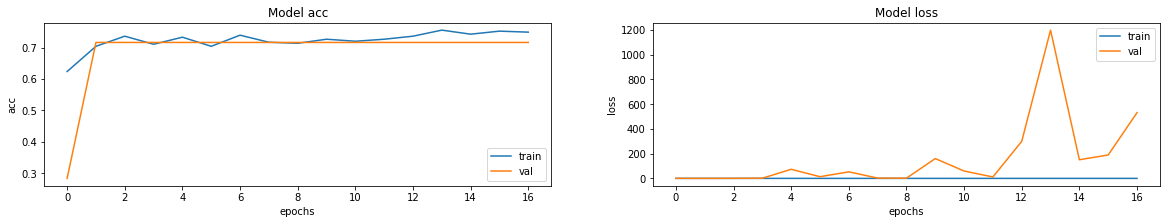

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [14]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 54.16 percent confident that CT scan is normal
This model is 45.84 percent confident that CT scan is abnormal
